In [325]:
import os
import requests
import pandas as pd
import json
from dotenv import load_dotenv
import hvplot.pandas
import numpy as np
%matplotlib "inline"

In [326]:
from nba_api.stats.static import players
from nba_api.stats.static import teams 
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.library.parameters import NumberOfGames, SeasonAll, SeasonTypeAllStar, LeagueIDNullable

In [327]:
#getting player's game ID
#how to use function: player_id("Player's Name")
#for example: team_id('LeBron James')

player_dict = players.get_players()
teams = teams.get_teams()

def player_id(playername):
    player = [player for player in player_dict if player['full_name'] == playername][0]
    player_id = player['id']
    return player_id

#getting team's ID
#how to use function: player_id("Team's Name") 
#for example: team_id('Golden State Warriors')
def team_id(teamname):
    team_find = [x for x in teams if x['full_name'] == teamname][0]
    team_id_no = team_find['id']
    return team_id_no

#creating a function to get player's data from specific year
#type game_log(playerID, season's year)
#for example: game_log(2544,2018)

def game_log(playerid,season):
    player_gamelog = playergamelog.PlayerGameLog(player_id = playerid, season = season)
    df_games = player_gamelog.get_data_frames()
    return df_games[0]

#creating a function to get a player's lifetime career in basketball
#type all_season_log(playerID using earlier function)
def all_season_log(playerid):
    gamelog_bron_all = playergamelog.PlayerGameLog(player_id = playerid, season = SeasonAll.all)
    df_bron_games_all = gamelog_bron_all.get_data_frames()
    return df_bron_games_all[0]

#creating a function to get a team's stats in basketball
#type bkb_teamlog(Team's ID using earlier function)

def bkb_teamlog(teamid):
    team_games = leaguegamefinder.LeagueGameFinder(team_id_nullable = teamid).get_data_frames()[0]
    return team_games

#Summary: 
# 1) player_id('Player's Name')
# 2) team_id('Team's Name')
# 3) game_log(playerid,season)
# 4) all_season_log(playerid)
# 5) bkb_teamlog(teamid)

In [328]:
bron_id = player_id('LeBron James')
chris_id = player_id('Chris Paul')
james_id = player_id('James Harden')

print(f"Lebron ID      : {bron_id}")
print(f"Chris Paul ID  : {chris_id}")
print(f"James Harden ID: {james_id}")

a = team_id('Cleveland Cavaliers')
b = team_id('Los Angeles Lakers')
c = team_id('Miami Heat')

print(f"Cleveland Cavaliers Team ID :{a}")
print(f"Los Angeles Lakers Team ID  :{b}")
print(f"Miami Heat Team ID          :{c}")

#'Cleveland Cavaliers', 'Los Angeles Lakers','Miami Heat'

Lebron ID      : 2544
Chris Paul ID  : 101108
James Harden ID: 201935
Cleveland Cavaliers Team ID :1610612739
Los Angeles Lakers Team ID  :1610612747
Miami Heat Team ID          :1610612748


In [329]:
#To extract team's raw data from a specific date

def team_raw_data(start_date, end_date, teamid):
    team_raw_data = bkb_teamlog(teamid)
    range = (team_raw_data['GAME_DATE'] >= start_date) & (team_raw_data['GAME_DATE'] <= end_date)
    date_extract_data = team_raw_data.loc[range]
    return date_extract_data

In [330]:
#without Lebron
cavs_DF1 = team_raw_data('1999-02-02','2003-04-16',1610612739)
miami_DF = team_raw_data('2004-11-02','2009-04-15',1610612748)
cavs_DF2 = team_raw_data('2007-10-30','2013-04-17',1610612739)
la_lakers_before_lebron = team_raw_data('2014-10-28','2018-04-11',1610612747)

#with Lebron
cavs_DF1_withlebron = team_raw_data('2006-10-31','2010-04-14',1610612739)
miami_DF_withlebron = team_raw_data('2010-10-26','2014-04-16',1610612748)
cavs_DF2_withlebron = team_raw_data('2014-10-28','2018-04-11',1610612739)
la_lakers_DF_withlebron = team_raw_data('2018-10-16','2022-04-04',1610612747)

In [331]:
#Use this function for dataframe extraction

def nba_analysis(dataframe):
    #Extracting only "Years" from "GAME_DATE"
    dataframe['Year'] = pd.DatetimeIndex(dataframe['GAME_DATE']).year
    team_DF = dataframe

    #Including columns with important parameters
    a = team_DF.loc[:,['GAME_DATE', 'Year', 'PTS','WL']]

    #Isolating PTS column and taking the average of all PTS
    main_DF = a.rename(columns={"PTS": "Mean PTS"})
    mean_DF = main_DF.groupby("Year").mean().reset_index()
    
    #Isolating PTS column and taking the sum of all PTS
    main_DF2 = a.rename(columns={"PTS": "Sum PTS"})
    sum_DF = main_DF2.groupby("Year").sum().reset_index()
    
    #creating for loop condition (years = [2012,2013,2014, ...])
    years = mean_DF['Year'].tolist()
    
    #creating empty dataframes for standard deviation & winrate%
    team_SD = pd.DataFrame()
    team_winrate = []
   
    #creating for loop to append yearly SD and winrate% into the empty dataframes
    for year in years:
        SD_points = main_DF.loc[main_DF['Year'] == year].std().drop("Year")
        a = list(SD_points)
        team_SD = team_SD.append(a)
     
        b = team_DF.loc[team_DF['Year'] == year]
        lal_WR = b['WL'].to_list()
        winrate_pct = (lal_WR.count('W')/len(lal_WR))*100
        team_winrate.append(winrate_pct)
    
        
    #parsing the dataframe
    WR_DF = pd.DataFrame(team_winrate) 
    WR_DF['Year'] = years
    WR_DF = WR_DF.set_index('Year').rename(columns={0: 'WR'})

    #creating standard deviation
    team_SD['Year'] = years
    SD_DF = team_SD.set_index('Year').rename(columns={0: 'SD'})

    #concatenate both mean & SD values on the same dataframe
    #set year as index so DF can be concat. properly
    mean_DF = mean_DF.set_index("Year")
    sum_DF = sum_DF.set_index("Year")
    main_DF = pd.concat([mean_DF, sum_DF, SD_DF, WR_DF,], axis='columns')
    
    #formating data into their appropriate format 
    #1 decimal for all mean,SD
    #1 showing 1 decimal% for WR
    
    main_DF = np.round(main_DF, decimals=2)
    
    return main_DF



In [332]:
nba_analysis(cavs_DF2)

C:\Users\yfkok\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Mean PTS,Sum PTS,SD,WR
Year,,,,
2007,95.48,2960,12.89,45.16
2008,95.86,10353,12.85,62.04
2009,98.51,11033,10.58,72.32
2010,98.02,10194,11.91,55.77
2011,96.38,5301,12.03,23.64
2012,92.61,9909,11.02,30.84
2013,98.18,4909,9.72,34.00


In [333]:
nba_analysis(cavs_DF2_withlebron)

C:\Users\yfkok\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Mean PTS,Sum PTS,SD,WR
Year,,,,
2014,101.50,3248,13.06,56.25
2015,100.31,11235,12.37,65.18
2016,106.17,12528,12.57,70.34
2017,109.46,12478,13.86,59.65
2018,111.50,5129,13.80,56.52


In [334]:

team_Q2_raw_data = team_raw_data('2010-10-26','2014-04-16',1610612748)
player_data = all_season_log('2544').rename(columns={'Game_ID': 'GAME_ID'})

team_raw_data = team_Q2_raw_data.loc[:,['GAME_ID', 'PTS']].rename(columns={'PTS': 'Team PTS'}).set_index("GAME_ID")
player_data = player_data.set_index("GAME_ID")

Q2_main_DF = pd.concat([player_data, team_raw_data], axis='columns', join='inner')

In [335]:
df = Q2_main_DF.reset_index()
game_id = df['GAME_ID'].tolist()

game_df = []

for id in game_id:
    player_impact = Q2_main_DF.loc[id,"PTS"] 
    + 0.4*Q2_main_DF.loc[id,"FGM"] 
    - 0.7*Q2_main_DF.loc[id,"FGA"]
    - 0.4*((Q2_main_DF.loc[id,"FTA"]-Q2_main_DF.loc[id,"FTM"]))
    + 0.7*Q2_main_DF.loc[id,"OREB"]
    + 0.3*Q2_main_DF.loc[id,"DREB"]
    + Q2_main_DF.loc[id,"STL"]
    + 0.7*Q2_main_DF.loc[id,"AST"]
    + 0.7*Q2_main_DF.loc[id,"BLK"]
    - 0.4*Q2_main_DF.loc[id,"PF"]
    - Q2_main_DF.loc[id,"TOV"]
    game_df.append(player_impact)

player_impact_list = game_df    

In [336]:
Q2_main_DF['player_impact_score'] = player_impact_list

In [337]:
Q2_main_DF['Year'] = pd.DatetimeIndex(Q2_main_DF['GAME_DATE']).year

player_impact_DF = Q2_main_DF.loc[:,["Year", "player_impact_score", "Team PTS"]]
#Year, player_impact_score, TeamPTS

player_impact_DF

,Year,player_impact_score,Team PTS
GAME_ID,,,
0021301192,2014,27,85
0021301180,2014,36,98
0021301167,2014,37,102
0021301158,2014,29,87
0021301149,2014,38,102
...,...,...,...
0021000050,2010,20,129
0021000040,2010,20,101
0021000025,2010,15,96


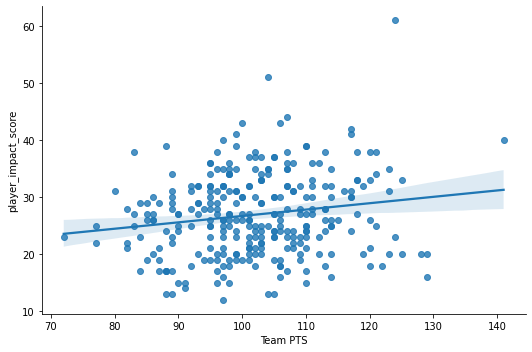

In [338]:
import seaborn as sns
sns.lmplot(x="Team PTS", y="player_impact_score", data=player_impact_DF, aspect=1.5, fit_reg=True)
